# Implementing Micrograd

In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [15]:
xs = np.arange(-10, 10, 0.1)
f = lambda x: x**2
ys = f(xs)

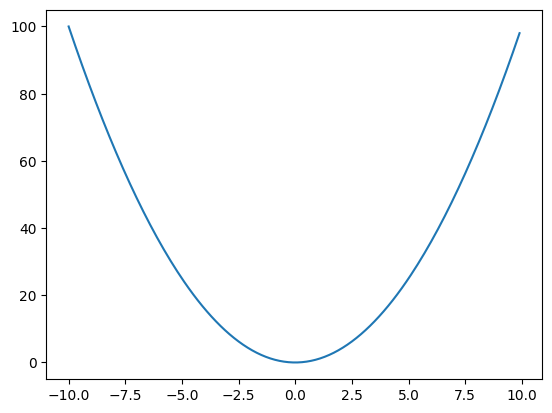

In [16]:
plt.plot(xs, ys)
plt.show()

### The Value Wrapper Class

This class is used to track the computations we make during the forward pass of a neural network. This is necessary as during the backward pass we must compute the gradients of the loss with respect to the input weights.

Using the graphviz library, we can visualise the forward pass and see how the "loss" is simply a large chain of operations from the inputs.

In [17]:
from typing import Iterable

In [18]:
class Value:
    """
    A wrapper class for float values to track operations and numbers for later use in backpropagation.

    Attributes:
        data: the float value of the node
        label: a string label for the node
        grad: the gradient of the loss with respect to this node
        _prev: a set of previous nodes that are used to compute an instance node
        _op: the operation used to compute an instance node

    """

    def __init__(self, data: float, _children: Iterable["Value"]  = (), _op: str= "", label = "") -> None:
        """
        Args:
            data: the float value of the node
            _children: the child nodes i.e. the nodes previously used to compute this node
            _op: the operation used to compute this node
        """
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(data={self.data})"

    def __add__(self, other: "Value") -> "Value":
        """non in-place addition"""
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other: "Value") -> "Value":
        """non in-place multiplication"""
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def tanh(self):
        return Value(math.tanh(self.data), (self,), "tanh")


In [19]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'TB'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



## Manual Backpropagation

Our goal with backprop in Neural Networks is to **compute the gradient** of some **loss function** with respect to its input **weights**.

We do this by recursively applying the chain rule from calculus.

*Example*:

Let's say that L is just some random function of input variables, c, a, b and f such that.

`L = d * f = (c + e) * f = (c + (a * b)) * f`

For each value in this process, we only record

1) The child nodes that created it.
2) The operation that created it (+ or *)

In theory, if we knew the full symbolic expression for L as shown above, we could calculate the gradients using basic calculus rules. However, since our computers can't afford have this luxury, we resort to an alternative method.

### The Chain Rule in Backprop

The first observation is that we can easily calculate the gradient of L with respect to d or f at the top level. Trivially, dL/dd = f and dL/df = d.

However, since d is a composite function made up of several other intermediary values, such as c and e, we need to somehow backpropogate this gradient backwards.

>**Insert the chain rule**:
>
> dL/dc = dL/dd * dd/dc

Unpacking this:

dL/dd is a value we trivially calculated as f. This can be thought of as some *error signal*, an indication of how much an overall shift in the composite function d impacts the loss function L.

But we want to know dL/dc (the gradient with respect to a specific input scalar c), not dL/dd.

The other component of the equation is dd/dc. This can be thought of as the *local gradient*, an indication of the amount that c changes d.

By the chain rule, if we multiply that error signal, the amount that d changes L, by the local gradient, the amount that c changes d (dd/dc), we get dL/dc as desired.


### Summary

Thus, given some output function L, we can recursively use this method, backpropagating the error signal + using the chain rule, to compute the gradients with respect to the individual input scalars influencing L. All without needing to symbolically evaluate the derivatives.







In [20]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

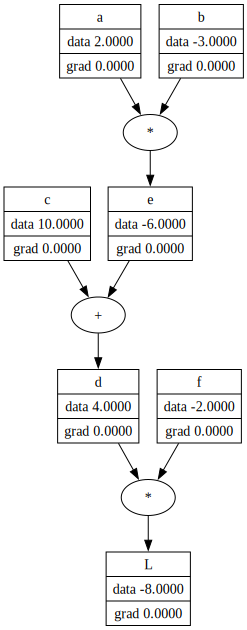

In [21]:
draw_dot(L)

In [22]:
L.grad = 1.0
d.grad = -2
f.grad = 4
c.grad = -2 * 1
e.grad = -2
a.grad = 6
b.grad = -4

In [23]:
def manual_forward_pass():
    """
    In this function, we can demonstrate that our asserted values of the gradients are correct by tweaking the input params by h and
    check the difference in output.
    """
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    # Add h to any of the inputs here to see the difference in L printed when you increase that input slightly
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0+h, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

manual_forward_pass()

-1.9999999999953388


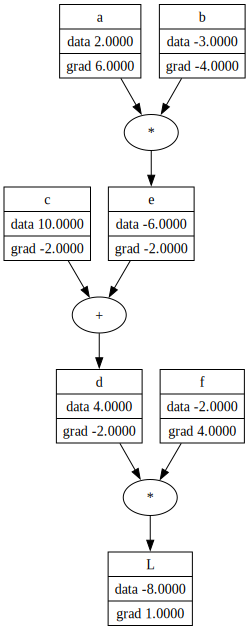

In [24]:
draw_dot(L)

## Single Layer Perceptron
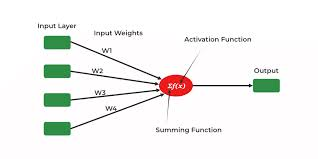

As shown above, a single neuron is just a linear combination of input variables (plus a bias term) passed through some arbitrary activation function.

Specifically,

> y = f(w1x1 + w2x2 + w3x3 + b)
>
> where f is the activation function, adding some nonlinearity to the output so we don't end up with a fancy linear regression.
>
> wi, i<-[1,2,3], are the weights of the input variables (scalars). They are like toggles that control the effect of the input variables xi on the output
>
> xi, i<-[1,2,3], are the input variables,=.
>
> b is a bias term, like a measure of how easily a neuron can be activated, large positive fires easily while negative is harder to activate

We can again use backpropagation manually to compute the gradients, but we don't have time for that so we can just pass in the variables rather than the hardcoded numbers.

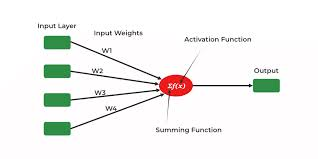

In [25]:
# First, we initialize the neuron, a function as discussed above. Initially we just have a tanh function.
#

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

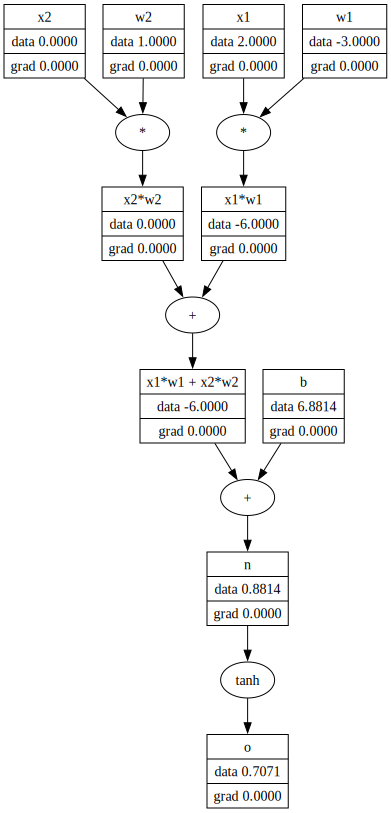

In [26]:
draw_dot(o)